In [ ]:
kf = KFold(n_splits=5, random_state=27, shuffle=False)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [199]:
#Dir path
#Case='NorthDakota'
#Case='Colorado'
Case='Idaho'
#Case='All'
crop='Potatoes'
#crop='Spring Wheat'
#crop='Sugarbeets'
#idaho potatoes 0.4
#ID wheat 0.3
#ID sugarbeets 0.4
#ND potatoes 0.38
#CO
#all potatoes 0.41
#all sugar 0.38 14 days

start_y=2008
end_y=2023


#Load the data
if Case=='All':
    timelog1=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+'NorthDakota'+'_240524_max09_df.h5')
    timelog2=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+'Colorado'+'_240524_max09_df.h5')
    timelog3=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+'Idaho'+'_240524_max09_df.h5')
    timelog=pd.concat([timelog1,timelog2,timelog3])
else:
    sites_pth = 'Data/'+Case+'/sites/'
    cdl_pth = 'Data/'+Case+'/cdl/'
    season_pth = 'Data/'+Case+'/season/'

    site_names = os.listdir(sites_pth)
    cdl_names = os.listdir(cdl_pth)
    season_names = os.listdir(season_pth)
    location=np.load('Data/'+Case+'/masklayers/wgscenterlist.npy')
    num_sites=len(site_names)
    timelog=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+Case+'_240524_max09_df.h5')

In [200]:
crop_encod_temp=timelog['Crop']
sorted_crop=np.unique(timelog['Crop'])[np.argsort(np.unique(timelog['Crop'], return_counts=True)[1])[::-1]]
crop_encod=[int(np.where(sorted_crop==value)[0][0]) for value in crop_encod_temp]#sorted_crop.index(value)
timelog['CropID']=crop_encod

In [190]:
sorted_crop

array(['Potatoes', 'Spring Wheat', 'Dry Beans', 'Sugarbeets', 'Barley',
       'Winter Wheat', 'Soybeans', '', 'Alfalfa', 'Durum Wheat', 'Corn',
       'Grassland/Pasture', 'Sorghum', 'Fallow/Idle Cropland',
       'Switchgrass', 'Mustard', 'Oats', 'Other Crops', 'Canola',
       'Shrubland', 'Other Hay/Non Alfalfa', 'Carrots', 'Asparagus',
       'Developed/Med Intensity', 'Developed/Low Intensity', 'Speltz',
       'Peas', 'Dbl Crop WinWht/Soybeans', 'Dbl Crop Triticale/Corn',
       'Rye', 'Sunflower', 'Lettuce', 'Triticale', 'Safflower'],
      dtype=object)

In [191]:
np.sort(np.unique(timelog['Crop'], return_counts=True)[1])[::-1]

array([8796, 5924, 3332, 2908, 2880, 2068, 1116,  708,  536,  516,  336,
        192,  188,  184,   76,   64,   52,   48,   48,   40,   32,   20,
         16,   12,    8,    8,    8,    4,    4,    4,    4,    4,    4,
          4], dtype=int64)

In [201]:
#Remove multiple crop cases
timelog=timelog[timelog['Multiple_crop'] == 0]
#subset crop
timelog=timelog[timelog['Crop'] == crop]
#timelog=timelog[timelog['CropID'] < 4]


In [193]:
timelog['DayOfYear'].quantile(0.99)

KeyError: 'DayOfYear'

In [202]:
timelog['DayOfYear'] = timelog['Timestamp'].dt.dayofyear

In [203]:
TimeLST=[]
NdviLST=[]
CropLST=[]
for i,e in enumerate(['Emergence','Maturity','Senescence','Dormancy']):
    TimeLST.append(timelog[timelog['Activity'] == e]['DayOfYear'].values)
    NdviLST.append(timelog[timelog['Activity'] == e]['NDVI_range'].values)
    CropLST.append(timelog[timelog['Activity'] == e]['Crop'].values)

In [204]:
NdviLST[0]=np.array([np.min(n) for n in NdviLST[0]])
NdviLST[1]=np.array([np.max(n) for n in NdviLST[1]])
NdviLST[2]=np.array([np.max(n) for n in NdviLST[2]])
NdviLST[3]=np.array([np.min(n) for n in NdviLST[3]])

In [205]:
data = {
    't1': TimeLST[0]-np.mean(TimeLST[1]),
    't2': TimeLST[1]-np.mean(TimeLST[2]),
    't3': TimeLST[2]-np.mean(TimeLST[3]),
    'n1': NdviLST[0]-np.mean(NdviLST[0]),
    'n2': NdviLST[1]-np.mean(NdviLST[1]),
    'n3': NdviLST[2]-np.mean(NdviLST[2]),
    'n4': NdviLST[3]-np.mean(NdviLST[3]),
    't4': (TimeLST[3]-np.mean(TimeLST[3])),
    'l1': TimeLST[1]-TimeLST[0],
    'l2': TimeLST[2]-TimeLST[1],
    'l3': TimeLST[2]-TimeLST[0],
    'cp': CropLST[0]
}
data = {
    't1': TimeLST[0],
    't2': TimeLST[1],
    't3': TimeLST[2],
    'n1': NdviLST[0],
    'n2': NdviLST[1],
    'n3': NdviLST[2],
    'nl1': NdviLST[1]-NdviLST[0],
    'nl2': NdviLST[2]-NdviLST[1],
    'nl3': NdviLST[2]-NdviLST[0],
    'n4': NdviLST[3],
    't4': (TimeLST[3]),
    'tl4': TimeLST[3]-TimeLST[0],#how long it takes from sen to dor
    'l1': TimeLST[1]-TimeLST[0],
    'l2': TimeLST[2]-TimeLST[1],
    'l3': TimeLST[2]-TimeLST[0],
    'cp': CropLST[0]
}
df = pd.DataFrame(data)
#X = df[['t1', 't2', 't3', 'n1', 'n2', 'n3', 'nl1','nl2', 'nl3','l1', 'l2','l3']]
X = df[['t1', 'n1', 'nl1','nl2', 'nl3','l1', 'l2','l3']]#by far the best score 0.38 with n = 20. tl4 = lst 3-0
#X = df[['t1', 't2', 't3', 'n1', 'n2', 'n3','l1', 'l2']]#by far the best score 0.25-0.3
#X = df[['t3','n3', 'l2']]
y = df['tl4']
#y = df['l3']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=27)
encoder_one_hot = OneHotEncoder()
#x_train = encoder_one_hot.fit_transform(x_train[['cp']])
#x_test = encoder_one_hot.transform(x_test[['cp']])

print(len(y_train),len(y_test))

471 53


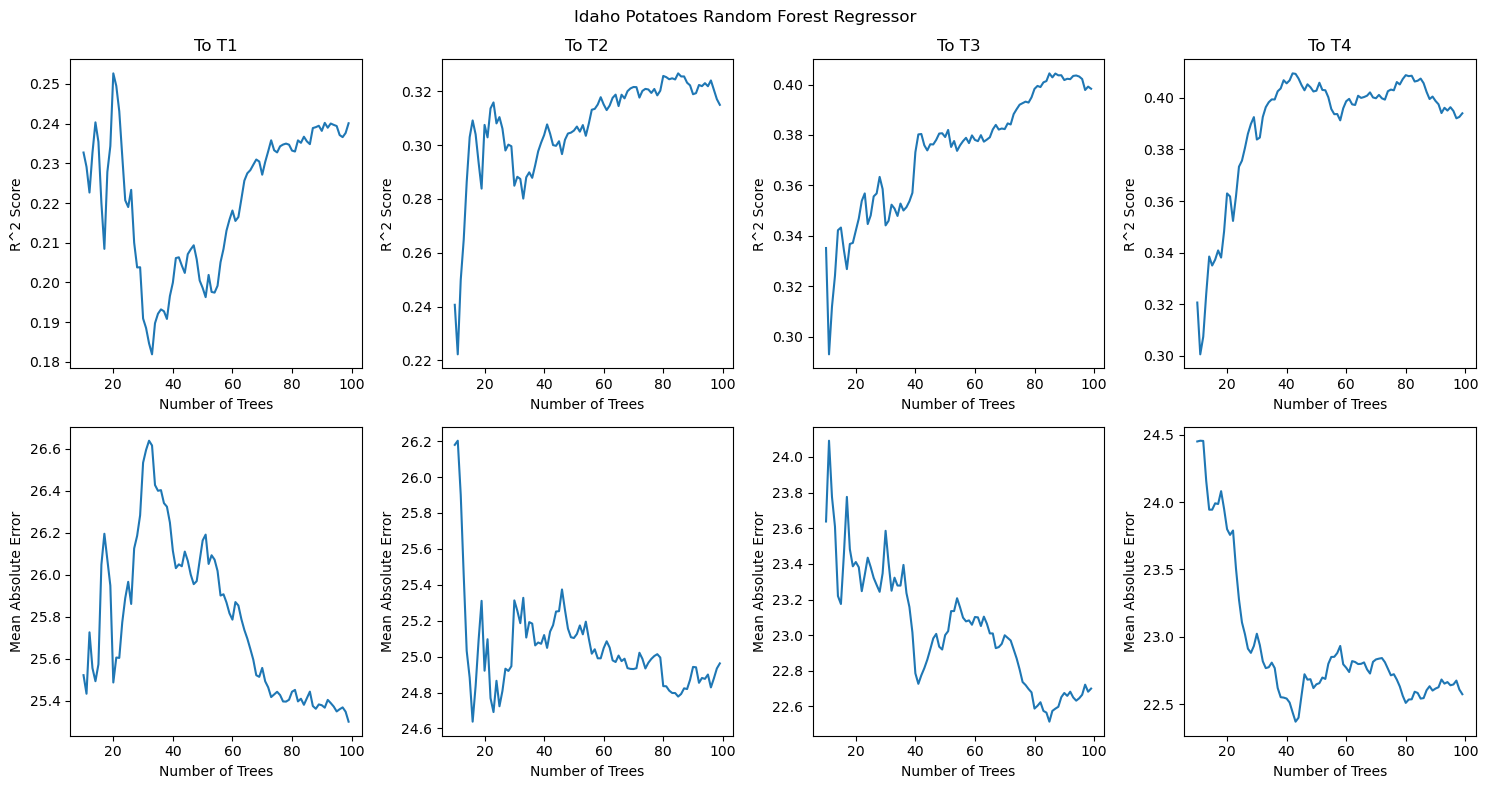

In [206]:
X1 = df[['t1', 'n1']]

X2 = df[['t1', 'n1', 'nl1','l1']]

X3 = df[['t1', 'n1', 'nl1','nl2','l1', 'l2']]

X4 = df[['t1', 'n1', 'nl1','nl2', 'nl3','l1', 'l2','l3']]
y = df['tl4']

fig, ax = plt.subplots(2, 4, figsize=(15, 8))
for i, X in enumerate([X1,X2,X3,X4]):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=27)

    r2_scores = []
    mae_scores = []
    for n in range(10,100):
        model = RandomForestRegressor(n_estimators=n, random_state=27)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
    ax[0,i].plot(range(10, 100), r2_scores)
    ax[0,i].set_xlabel('Number of Trees')
    ax[0,i].set_ylabel('R^2 Score')
    ax[0,i].set_title(f'To T{i+1}')

    ax[1,i].plot(range(10,100), mae_scores)
    ax[1,i].set_xlabel('Number of Trees')
    ax[1,i].set_ylabel('Mean Absolute Error')
plt.suptitle(Case+' '+crop+' Random Forest Regressor')
plt.tight_layout()
plt.show()

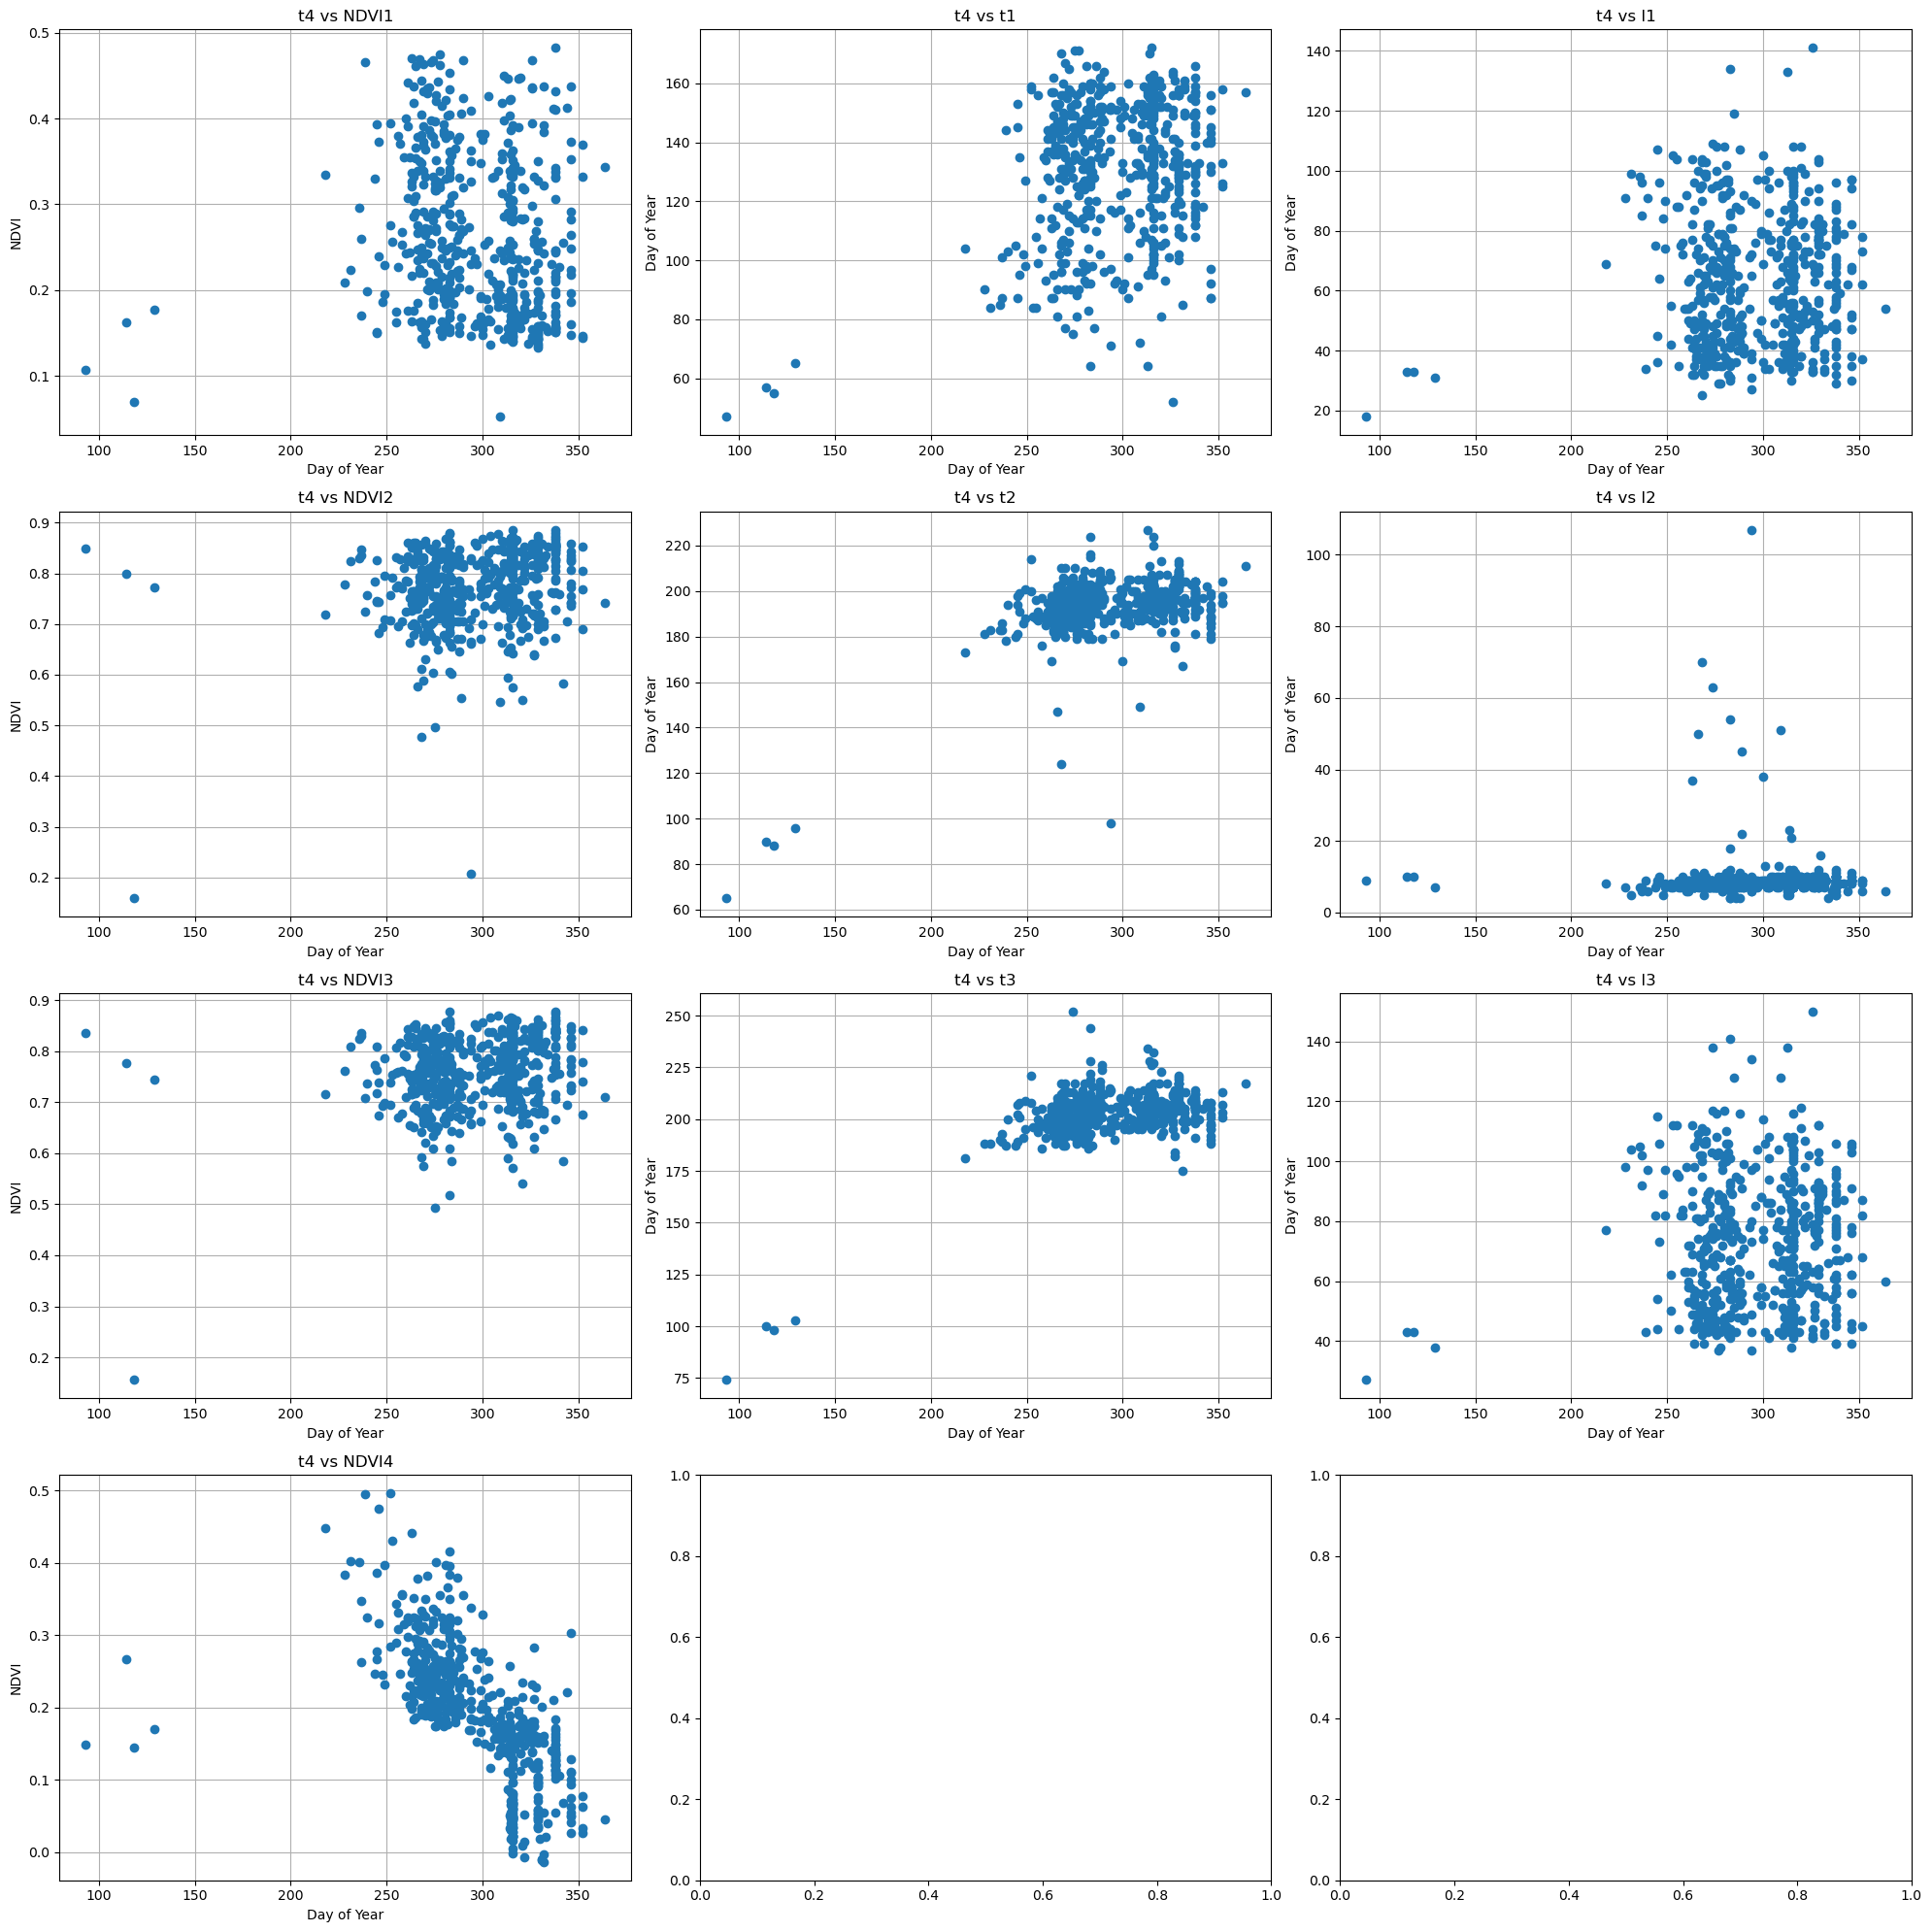

In [77]:
fig,ax=plt.subplots(4, 3, figsize=(20, 20))
#ax=ax.ravel()

ax[0,0].plot((df['t4']),(df['n1']),'o')
ax[0,0].set_ylabel('NDVI')
ax[0,0].set_xlabel('Day of Year')
ax[0,0].set_title('t4 vs NDVI1')
ax[0,0].grid()


ax[1,0].plot((df['t4']),(df['n2']),'o')
ax[1,0].set_ylabel('NDVI')
ax[1,0].set_xlabel('Day of Year')
ax[1,0].set_title('t4 vs NDVI2')
ax[1,0].grid()

ax[2,0].plot((df['t4']),(df['n3']),'o')
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xlabel('Day of Year')
ax[2,0].set_title('t4 vs NDVI3')
ax[2,0].grid()

ax[3,0].plot(df['t4'],df['n4'],'o')
ax[3,0].set_ylabel('NDVI')
ax[3,0].set_xlabel('Day of Year')
ax[3,0].set_title('t4 vs NDVI4')
ax[3,0].grid()

ax[0,1].plot((df['t4']),(df['t1']),'o')
ax[0,1].set_ylabel('Day of Year')
ax[0,1].set_xlabel('Day of Year')
ax[0,1].set_title('t4 vs t1')
ax[0,1].grid()


ax[1,1].plot((df['t4']),(df['t2']),'o')
ax[1,1].set_ylabel('Day of Year')
ax[1,1].set_xlabel('Day of Year')
ax[1,1].set_title('t4 vs t2')
ax[1,1].grid()

ax[2,1].plot((df['t4']),(df['t3']),'o')
ax[2,1].set_ylabel('Day of Year')
ax[2,1].set_xlabel('Day of Year')
ax[2,1].set_title('t4 vs t3')
ax[2,1].grid()

ax[0,2].plot((df['t4']),(df['l1']),'o')
ax[0,2].set_ylabel('Day of Year')
ax[0,2].set_xlabel('Day of Year')
ax[0,2].set_title('t4 vs l1')
ax[0,2].grid()


ax[1,2].plot((df['t4']),(df['l2']),'o')
ax[1,2].set_ylabel('Day of Year')
ax[1,2].set_xlabel('Day of Year')
ax[1,2].set_title('t4 vs l2')
ax[1,2].grid()

ax[2,2].plot((df['t4']),(df['l3']),'o')
ax[2,2].set_ylabel('Day of Year')
ax[2,2].set_xlabel('Day of Year')
ax[2,2].set_title('t4 vs l3')
ax[2,2].grid()
plt.tight_layout()

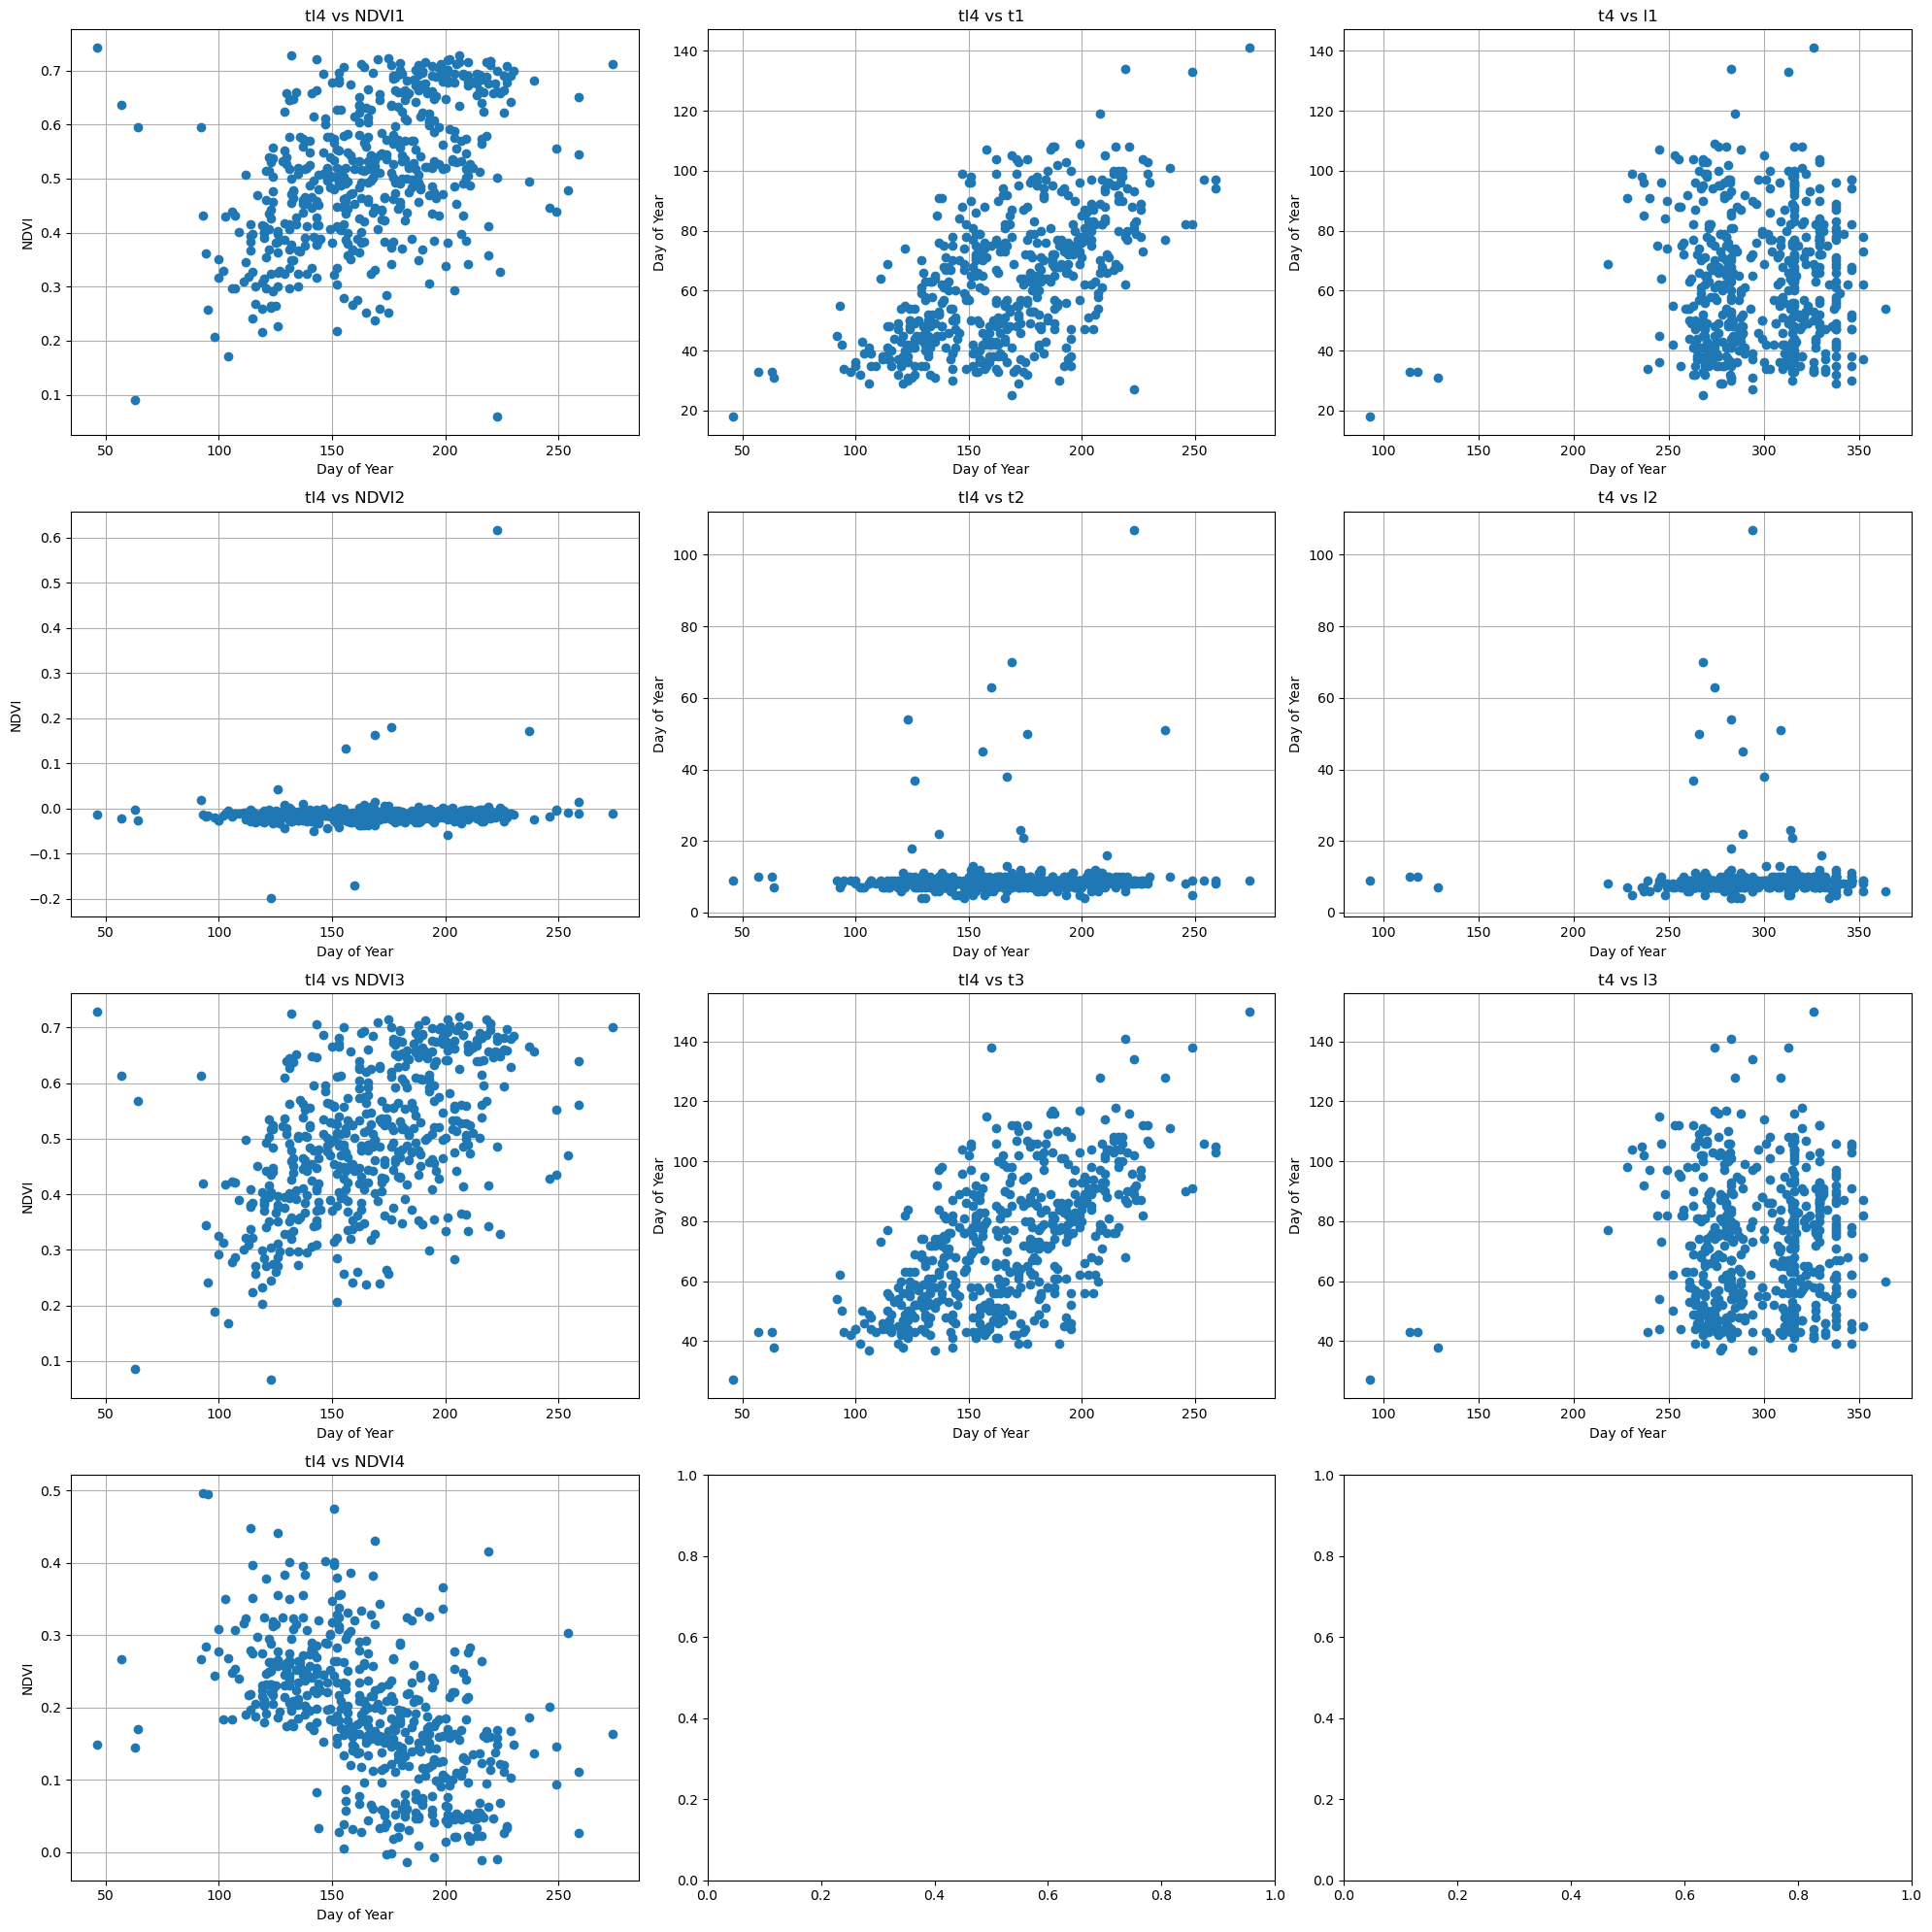

In [78]:
fig,ax=plt.subplots(4, 3, figsize=(20, 20))
#ax=ax.ravel()

ax[0,0].plot((df['tl4']),(df['nl1']),'o')
ax[0,0].set_ylabel('NDVI')
ax[0,0].set_xlabel('Day of Year')
ax[0,0].set_title('tl4 vs NDVI1')
ax[0,0].grid()


ax[1,0].plot((df['tl4']),(df['nl2']),'o')
ax[1,0].set_ylabel('NDVI')
ax[1,0].set_xlabel('Day of Year')
ax[1,0].set_title('tl4 vs NDVI2')
ax[1,0].grid()

ax[2,0].plot((df['tl4']),(df['nl3']),'o')
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xlabel('Day of Year')
ax[2,0].set_title('tl4 vs NDVI3')
ax[2,0].grid()

ax[3,0].plot(df['tl4'],df['n4'],'o')
ax[3,0].set_ylabel('NDVI')
ax[3,0].set_xlabel('Day of Year')
ax[3,0].set_title('tl4 vs NDVI4')
ax[3,0].grid()

ax[0,1].plot((df['tl4']),(df['l1']),'o')
ax[0,1].set_ylabel('Day of Year')
ax[0,1].set_xlabel('Day of Year')
ax[0,1].set_title('tl4 vs t1')
ax[0,1].grid()


ax[1,1].plot((df['tl4']),(df['l2']),'o')
ax[1,1].set_ylabel('Day of Year')
ax[1,1].set_xlabel('Day of Year')
ax[1,1].set_title('tl4 vs t2')
ax[1,1].grid()

ax[2,1].plot((df['tl4']),(df['l3']),'o')
ax[2,1].set_ylabel('Day of Year')
ax[2,1].set_xlabel('Day of Year')
ax[2,1].set_title('tl4 vs t3')
ax[2,1].grid()

ax[0,2].plot((df['t4']),(df['l1']),'o')
ax[0,2].set_ylabel('Day of Year')
ax[0,2].set_xlabel('Day of Year')
ax[0,2].set_title('t4 vs l1')
ax[0,2].grid()


ax[1,2].plot((df['t4']),(df['l2']),'o')
ax[1,2].set_ylabel('Day of Year')
ax[1,2].set_xlabel('Day of Year')
ax[1,2].set_title('t4 vs l2')
ax[1,2].grid()

ax[2,2].plot((df['t4']),(df['l3']),'o')
ax[2,2].set_ylabel('Day of Year')
ax[2,2].set_xlabel('Day of Year')
ax[2,2].set_title('t4 vs l3')
ax[2,2].grid()
plt.tight_layout()

In [13]:
print(df.corr())


           t1        t2        t3        n1        n2        n3       nl1  \
t1   1.000000  0.520618  0.335236  0.608813  0.113234  0.231028 -0.292351   
t2   0.520618  1.000000  0.768129  0.168069  0.084357  0.128096 -0.037203   
t3   0.335236  0.768129  1.000000  0.127836  0.112956 -0.075573  0.011679   
n1   0.608813  0.168069  0.127836  1.000000  0.068901  0.108376 -0.576130   
n2   0.113234  0.084357  0.112956  0.068901  1.000000  0.878647  0.775719   
n3   0.231028  0.128096 -0.075573  0.108376  0.878647  1.000000  0.651323   
nl1 -0.292351 -0.037203  0.011679 -0.576130  0.775719  0.651323  1.000000   
nl2  0.265218  0.105712 -0.374202  0.094168 -0.082395  0.403452 -0.127076   
nl3 -0.172675  0.007711 -0.143097 -0.517049  0.714484  0.794879  0.912456   
n4  -0.136323 -0.144085 -0.050326 -0.089961 -0.065149 -0.088253  0.003531   
t4   0.189167  0.307603  0.220995  0.033220  0.228197  0.235720  0.165949   
tl4 -0.372980  0.003416  0.023860 -0.304507  0.153149  0.095268  0.318102   

C:\Users\Vito\AppData\Local\Temp\ipykernel_22064\308504422.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


In [14]:
print(df.cov())

             t1          t2          t3        n1        n2        n3  \
t1   215.887724   80.867140   58.119644  0.294408  0.070920  0.157601   
t2    80.867140  111.757826   95.814588  0.058476  0.038014  0.062872   
t3    58.119644   95.814588  139.225020  0.049644  0.056813 -0.041401   
n1     0.294408    0.058476    0.049644  0.001083  0.000097  0.000166   
n2     0.070920    0.038014    0.056813  0.000097  0.001817  0.001739   
n3     0.157601    0.062872   -0.041401  0.000166  0.001739  0.002156   
nl1   -0.223488   -0.020462    0.007170 -0.000987  0.001720  0.001573   
nl2    0.086681    0.024858   -0.098214  0.000069 -0.000078  0.000417   
nl3   -0.136807    0.004396   -0.091044 -0.000918  0.001642  0.001990   
n4    -0.218075   -0.165836   -0.064651 -0.000322 -0.000302 -0.000446   
t4    69.941893   81.828954   65.617188  0.027512  0.244776  0.275394   
tl4 -145.945831    0.961814    7.497544 -0.266895  0.173855  0.117793   
l1  -135.020584   30.890687   37.694944 -0.235932 -

C:\Users\Vito\AppData\Local\Temp\ipykernel_22064\615776904.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())


C:\Users\Vito\AppData\Local\Temp\ipykernel_22064\1635920665.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.cov())


<Axes: >

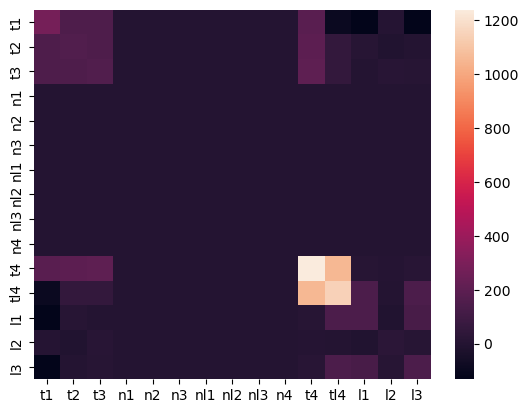

In [35]:
sns.heatmap(df.cov())

C:\Users\Vito\AppData\Local\Temp\ipykernel_22064\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

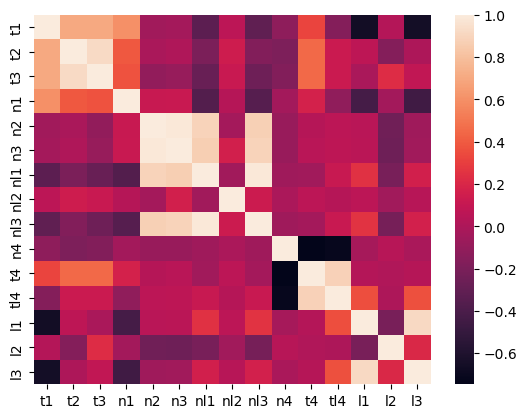

In [36]:
sns.heatmap(df.corr())

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm

# Calculate VIF for each feature
X_with_const = sm.tools.tools.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif)

  Variable         VIF
0    const  584.395135
1       t1    2.368697
2       n1    1.689826
3      nl1         inf
4      nl2         inf
5      nl3         inf
6       l1         inf
7       l2         inf
8       l3         inf


c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [180]:
r2_scores = []
mae_scores = []
for n in range(10,100):
    model = RandomForestRegressor(n_estimators=n, random_state=27)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    
plt.plot(range(10, 100), r2_scores)
plt.xlabel('Number of Trees')
plt.ylabel('R^2 Score')
plt.show()

plt.plot(range(10,100), mae_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.show()

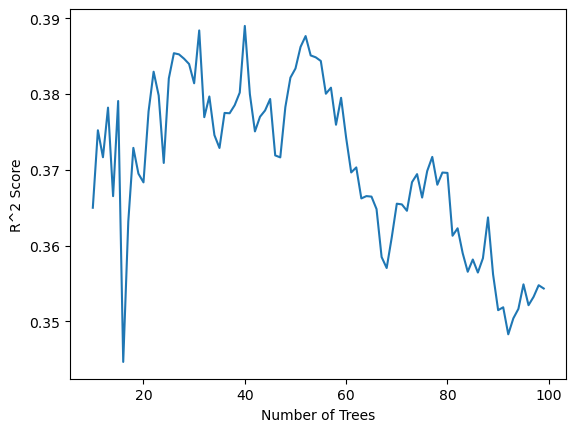

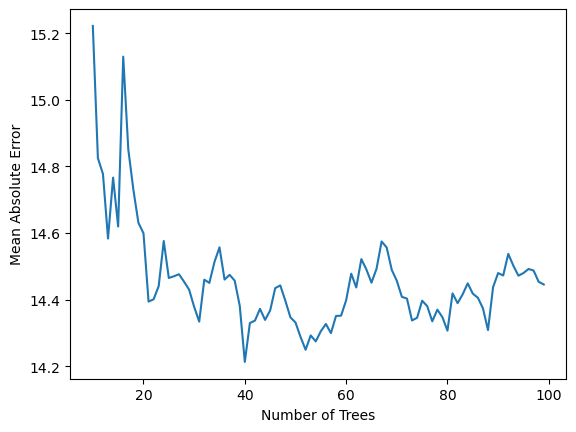

In [181]:
plt.plot(range(10, 100), r2_scores)
plt.xlabel('Number of Trees')
plt.ylabel('R^2 Score')
plt.show()

plt.plot(range(10,100), mae_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.show()

In [182]:
model = RandomForestRegressor(n_estimators=40, random_state=27)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.38898395030311184
14.212727272727273


In [21]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.1622500917825621
20.18928193086317


In [264]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.9)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.0970857144861067
20.57543745201074


In [233]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2  # Degree of the polynomial
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.028785012067516047
20.116832941547752


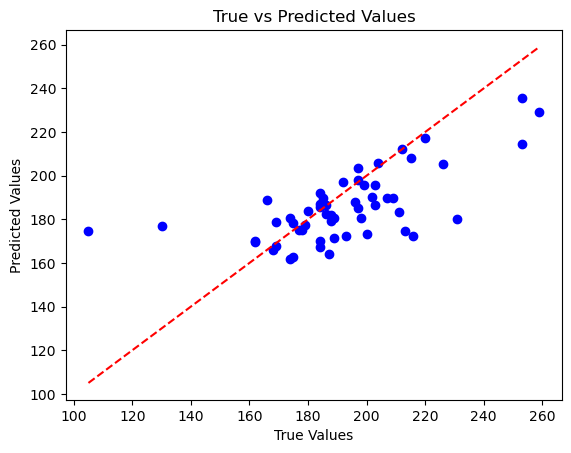

In [183]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

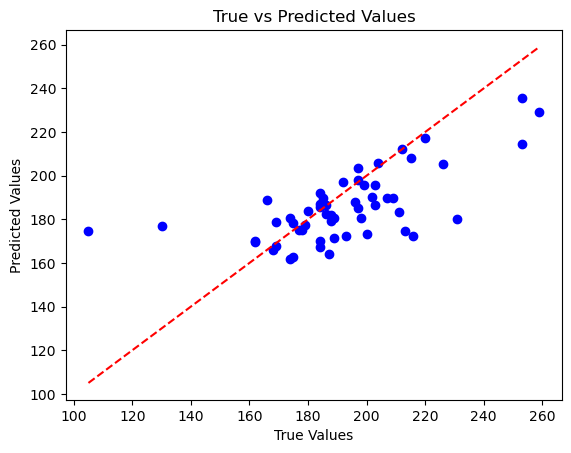

In [ ]:
#all sugar
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

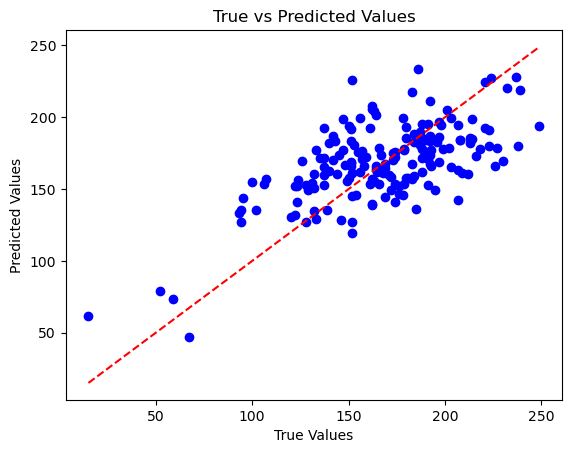

In [ ]:
#all potatoes
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()